In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import seaborn as sns
from params import *

In [3]:
# mode = 'save'
mode = 'load'

In [4]:
if mode == 'save':
    da_Pxx = None
    for patient in patients:
        print(patient)
        da = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
        for chan in da.coords['chan']:
            for stage in compute_stages :
                sig = da.loc[stage,chan,:].dropna('time').values
                # print(np.mean(sig), np.std(sig))
                f, Pxx = signal.welch(sig, fs = srate, nperseg = srate * 50 , nfft = srate * 100)
                if da_Pxx is None:
                    da_Pxx = gh.init_da({'patient':patients, 'stage':compute_stages, 'chan':da.coords['chan'], 'normalisation':['raw','normal'], 'freq':f})

                da_Pxx.loc[patient, stage, chan, 'normal', : ] = (Pxx - np.mean(Pxx)) / np.std(Pxx)
                da_Pxx.loc[patient, stage, chan, 'raw', : ] = Pxx
    da_Pxx.to_netcdf('../dataarray/da_pxx_all.nc')
else:
    da_Pxx = xr.load_dataarray('../dataarray/da_pxx_all.nc')

In [5]:
da_Pxx

<xarray.DataArray (patient: 10, stage: 4, chan: 11, normalisation: 2, freq: 12801)>
array([[[[[ 2.18906473e+02,  5.94439549e+02,  9.38105897e+02, ...,
            1.93769301e-01,  2.28496622e-01,  1.22984942e-01],
          [ 1.54003930e+00,  4.32799151e+00,  6.87936558e+00, ...,
           -8.36807002e-02, -8.34228851e-02, -8.42062023e-02]],

         [[ 4.33366540e+01,  1.51502593e+02,  2.54336602e+02, ...,
            2.84358318e-01,  3.41843508e-01,  1.84983046e-01],
          [ 1.54469902e+00,  5.72313535e+00,  9.69559989e+00, ...,
           -1.18405636e-01, -1.16184991e-01, -1.22244490e-01]],

         [[ 2.91135432e+02,  9.24643517e+02,  1.60450532e+03, ...,
            7.70379160e-02,  8.52464863e-02,  4.46914324e-02],
          [ 3.64343938e+00,  1.17933489e+01,  2.05395863e+01, ...,
           -1.00947827e-01, -1.00842226e-01, -1.01363956e-01]],

         ...,

         [[ 2.36686921e+00,  8.42538864e+00,  1.46555876e+01, ...,
            3.19640530e-05,  3.10253197e-05,  1.52185825e-05],
          [ 2.22634023e-01,  9.67155974e-01,  1.73277535e+00, ...,
...
            6.27174114e-02,  5.63151563e-02,  2.68300365e-02],
          [-1.31654028e-02,  1.76215367e-01,  3.61209636e-01, ...,
           -1.08288623e-01, -1.08373185e-01, -1.08762626e-01]],

         ...,

         [[ 4.68390450e+00,  9.01081923e+00,  8.18879077e+00, ...,
            2.64712304e-05,  2.95486999e-05,  1.56375609e-05],
          [ 1.05849688e-02,  4.61985516e-02,  3.94326732e-02, ...,
           -2.79666754e-02, -2.79666501e-02, -2.79667646e-02]],

         [[ 1.79933896e+04,  6.35402884e+04,  1.80770962e+05, ...,
            5.10416222e-02,  4.89487808e-02,  2.38401681e-02],
          [ 1.76675824e-01,  7.60266160e-01,  2.26233744e+00, ...,
           -5.38720021e-02, -5.38720289e-02, -5.38723506e-02]],

         [[ 2.32732634e+02,  5.71203659e+02,  8.08011121e+02, ...,
            1.81283147e-01,  1.83082321e-01,  8.97878923e-02],
          [-1.56365749e-01, -3.34362160e-02,  5.25700549e-02, ...,
           -2.40826240e-01, -2.40825586e-01, -2.40859470e-01]]]]])
Coordinates:
  * patient        (patient) object 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P8' 'P9' 'P10'
  * stage          (stage) object 'W' 'R' 'N2' 'N3'
  * chan           (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'THERM' 'ECG'
  * normalisation  (normalisation) object 'raw' 'normal'
  * freq           (freq) float64 0.0 0.01 0.02 0.03 ... 128.0 128.0 128.0 128.0

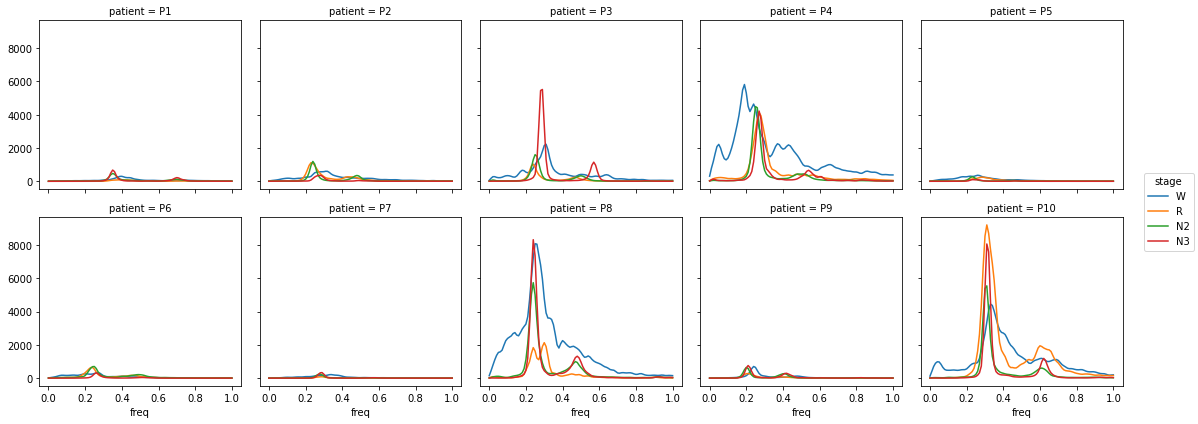

In [6]:
da_Pxx.loc[:,:,'DEBIT','raw',0:1].plot.line(x='freq',col='patient',hue = 'stage', col_wrap = 5)

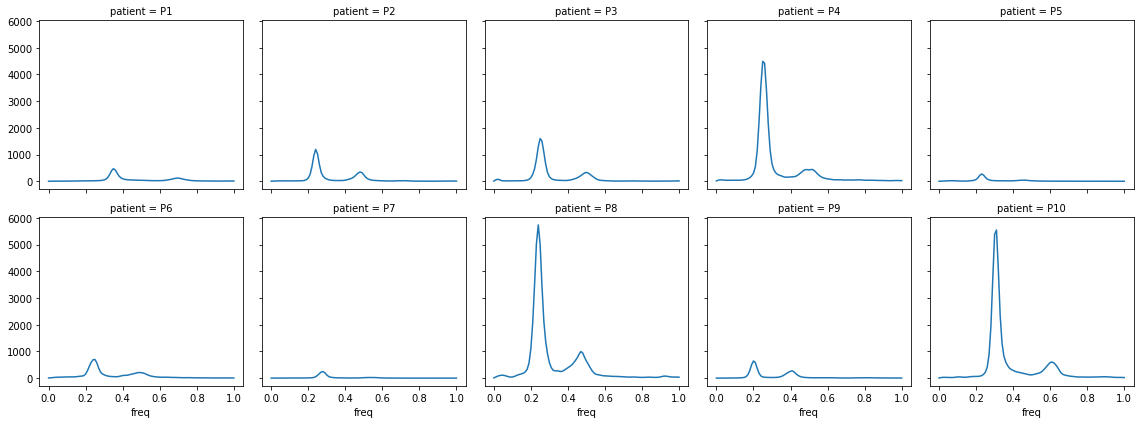

In [22]:
da_Pxx.loc[:,'N2','DEBIT','raw',0:1].plot.line(x='freq',col='patient', col_wrap = 5)

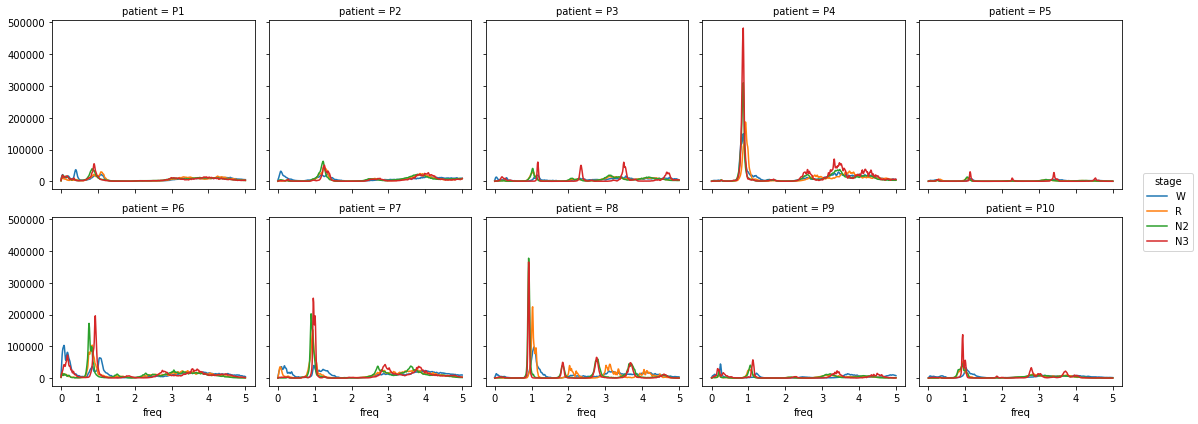

In [20]:
da_Pxx.loc[:,:,'ECG','raw',0:5].plot.line(x='freq',col='patient',hue = 'stage', col_wrap = 5)

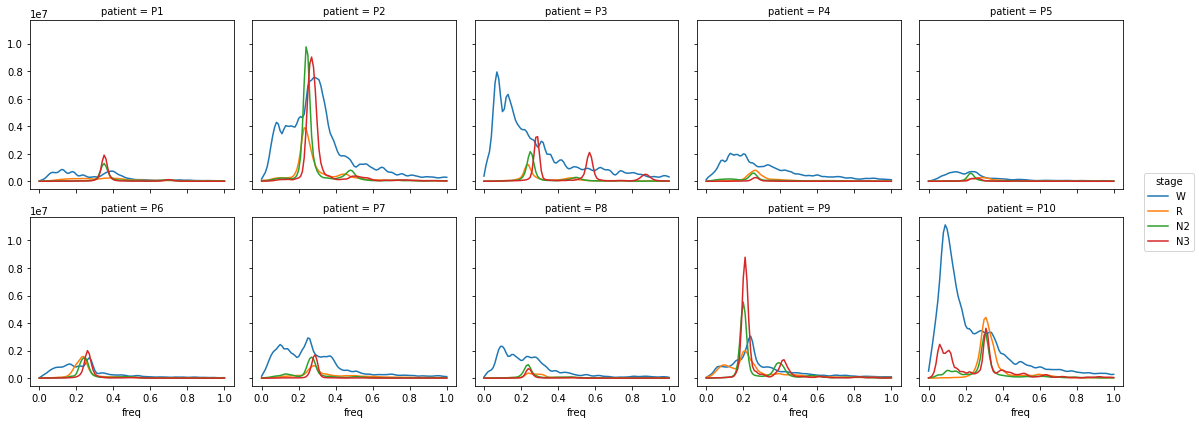

In [17]:
da_Pxx.loc[:,:,'THERM','raw',0:1].plot.line(x='freq',col='patient',hue = 'stage', col_wrap = 5)

In [7]:
rows = []
for patient in patients:
    for stage in compute_stages:
        for capteur in ['DEBIT','THERM']:
                fmax = float(da_Pxx.loc[patient,stage,capteur,'raw',0:0.7].idxmax().values)
                vmax = float(da_Pxx.loc[patient,stage,capteur,'raw',0:0.7].max().values)
                rows.append([patient, stage, capteur, fmax, vmax])
df_rsp = pd.DataFrame(rows, columns = ['patient', 'stage','capteur', 'fmax','vmax'])

In [8]:
df_rsp

,patient,stage,capteur,fmax,vmax
0,P1,W,DEBIT,0.40,2.983647e+02
1,P1,W,THERM,0.12,8.550277e+05
2,P1,R,DEBIT,0.42,8.706852e+01
3,P1,R,THERM,0.38,2.417547e+05
4,P1,N2,DEBIT,0.35,4.726187e+02
...,...,...,...,...,...
75,P10,R,THERM,0.31,4.415742e+06
76,P10,N2,DEBIT,0.31,5.546814e+03
77,P10,N2,THERM,0.31,3.196945e+06
78,P10,N3,DEBIT,0.31,8.065595e+03


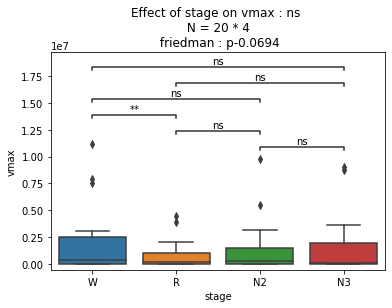

/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warning

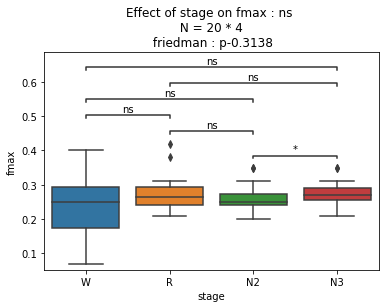

In [9]:
for outcome in ['vmax','fmax']:
    gh.auto_stats(df= df_rsp, predictor = 'stage', outcome = outcome, design = 'within', subject = 'patient', transform = False)
    plt.show()

* La fréquence respi et l'amplitude respi ne semblent pas varier de stade en stade, simplement + de variabilité en Wake que le reste

In [10]:
da_Pxx

<xarray.DataArray (patient: 10, stage: 4, chan: 11, normalisation: 2, freq: 12801)>
array([[[[[ 2.18906473e+02,  5.94439549e+02,  9.38105897e+02, ...,
            1.93769301e-01,  2.28496622e-01,  1.22984942e-01],
          [ 1.54003930e+00,  4.32799151e+00,  6.87936558e+00, ...,
           -8.36807002e-02, -8.34228851e-02, -8.42062023e-02]],

         [[ 4.33366540e+01,  1.51502593e+02,  2.54336602e+02, ...,
            2.84358318e-01,  3.41843508e-01,  1.84983046e-01],
          [ 1.54469902e+00,  5.72313535e+00,  9.69559989e+00, ...,
           -1.18405636e-01, -1.16184991e-01, -1.22244490e-01]],

         [[ 2.91135432e+02,  9.24643517e+02,  1.60450532e+03, ...,
            7.70379160e-02,  8.52464863e-02,  4.46914324e-02],
          [ 3.64343938e+00,  1.17933489e+01,  2.05395863e+01, ...,
           -1.00947827e-01, -1.00842226e-01, -1.01363956e-01]],

         ...,

         [[ 2.36686921e+00,  8.42538864e+00,  1.46555876e+01, ...,
            3.19640530e-05,  3.10253197e-05,  1.52185825e-05],
          [ 2.22634023e-01,  9.67155974e-01,  1.73277535e+00, ...,
...
            6.27174114e-02,  5.63151563e-02,  2.68300365e-02],
          [-1.31654028e-02,  1.76215367e-01,  3.61209636e-01, ...,
           -1.08288623e-01, -1.08373185e-01, -1.08762626e-01]],

         ...,

         [[ 4.68390450e+00,  9.01081923e+00,  8.18879077e+00, ...,
            2.64712304e-05,  2.95486999e-05,  1.56375609e-05],
          [ 1.05849688e-02,  4.61985516e-02,  3.94326732e-02, ...,
           -2.79666754e-02, -2.79666501e-02, -2.79667646e-02]],

         [[ 1.79933896e+04,  6.35402884e+04,  1.80770962e+05, ...,
            5.10416222e-02,  4.89487808e-02,  2.38401681e-02],
          [ 1.76675824e-01,  7.60266160e-01,  2.26233744e+00, ...,
           -5.38720021e-02, -5.38720289e-02, -5.38723506e-02]],

         [[ 2.32732634e+02,  5.71203659e+02,  8.08011121e+02, ...,
            1.81283147e-01,  1.83082321e-01,  8.97878923e-02],
          [-1.56365749e-01, -3.34362160e-02,  5.25700549e-02, ...,
           -2.40826240e-01, -2.40825586e-01, -2.40859470e-01]]]]])
Coordinates:
  * patient        (patient) object 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P8' 'P9' 'P10'
  * stage          (stage) object 'W' 'R' 'N2' 'N3'
  * chan           (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'THERM' 'ECG'
  * normalisation  (normalisation) object 'raw' 'normal'
  * freq           (freq) float64 0.0 0.01 0.02 0.03 ... 128.0 128.0 128.0 128.0

In [11]:
bands = {'delta':(0,4), 'theta':(4,8),'alpha':(8,12),'sigma':(12,15),'beta':(15,30),'low gamma':(30,45), 'high gamma':(55,80)}

In [12]:
rows = []
for patient in patients:
    for stage in compute_stages:
        for chan in eeg_chans:
            for band in bands.keys():
                trapz = float(da_Pxx.loc[patient,stage,chan,'raw',bands[band][0]:bands[band][1]].integrate('freq').values)
                rows.append([patient, stage, chan , band, trapz])
df_trapz = pd.DataFrame(rows, columns = ['patient', 'stage', 'chan','band','power'])

In [13]:
df_trapz[df_trapz['band'] == 'sigma'].groupby('chan').mean()

,power
chan,
C3-T3,3.585452
C4-T4,3.413367
Cz-Pz,2.463921
Fp1-C3,4.644652
Fp2-C4,4.255335
Fz-Cz,3.132174
T3-O1,3.745688
T4-O2,3.794884


In [14]:
df_trapz.groupby(['band','stage']).mean()

power
band       stage             
alpha      N2        9.146836
           N3        9.425590
           R         6.264677
           W        28.832133
beta       N2        3.186125
           N3        2.234577
           R         3.047710
           W        25.051511
delta      N2      415.807033
           N3     1148.719599
           R       554.904384
           W      3423.355921
high gamma N2        1.814119
           N3        1.004999
           R         1.505399
           W        34.861546
low gamma  N2        1.249090
           N3        0.735072
           R         1.254865
           W        23.452594
sigma      N2        5.243707
           N3        3.516616
           R         1.206112
           W         4.551301
theta      N2       17.860964
           N3       28.564141
           R        11.849351
           W        34.984171

In [15]:
df_trapz.groupby('band').mean()

,power
band,
alpha,13.417309
beta,8.379981
delta,1385.696734
high gamma,9.796516
low gamma,6.672905
sigma,3.629434
theta,23.314657


In [16]:
df_trapz.groupby('chan').mean().sort_values('Sigma Power')

KeyError: 'Sigma Power'

In [ ]:
fig, axs = plt.subplots(nrows = 2, figsize =  (20,20))
for i,predictor in enumerate(['stage','chan']):
    ax = axs[i]
    ax = gh.auto_stats(df=df_trapz, predictor = predictor, outcome = 'Sigma Power', design = 'within', subject = 'patient', ax=ax)

In [ ]:
fig, axs = plt.subplots(nrows = len(bands.keys()), figsize = (10,20), constrained_layout = True)
for i,band in enumerate(bands.keys()):
    ax = axs[i]
    sns.lineplot(data=df_trapz[df_trapz['band'] == band], x='stage', y = 'power', err_style = 'bars', markers=True,ax=ax)
    ax.set_title(band)
plt.show()